In [1]:
import xgcm
import xarray as xr
import numpy as np
from xbasin import remap_vertical, compute_moc
from matplotlib import pyplot as plt
import cmocean as cm

We open the example data and create 2 grids: 1 for the dataset we have and 1 for the remapped one.
Here '_fr' means *from* and '_to' *to* (i.e. remapped data).

In [2]:
#ds = xr.open_dataset('data/nemo_output_ex.nc')

In [3]:
from xnemogcm import open_nemo_and_domain_cfg

ds = open_nemo_and_domain_cfg(datadir='/home/romain/Documents/Education/PhD/Courses/2019-OC6310/Project/Experiments/EXP_eos00/Rawdata')

In [4]:
metrics_fr = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w']
}
metrics_to = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t_1d', 'e3w_1d']
}
grid_fr = xgcm.Grid(ds, periodic=False, metrics=metrics_fr)
grid_to = xgcm.Grid(ds, periodic=False, metrics=metrics_to)

print(ds)

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, t: 5, x_c: 21, x_f: 21, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * z_f            (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
  * t              (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19 20
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 17.5 18.5 19.5 20.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 36.5 37.5 38.5 39.5
Dimensions without coordinates: axis_nbounds
Data variables:
    depthw_bounds  (z_f, axis_nbounds) float32 ...
    t_bounds       (t, axis_nbounds) object ...
    woce           (t, z_f, y_c, x_c) float32 ...
    e3w            (t, z_f, y_c, x_c) float32 ...
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t         

We remap

In [5]:
vo_to = remap_vertical(
    ds.vo,
    grid_fr,
    grid_to,
    axis='Z'
)
print(vo_to.coords)

Coordinates:
  * z_c      (z_c) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * t        (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c      (x_c) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5


# We now compute the overturning stream function

## In depth coordinates

In [6]:
vmax = 9
vmin = -vmax

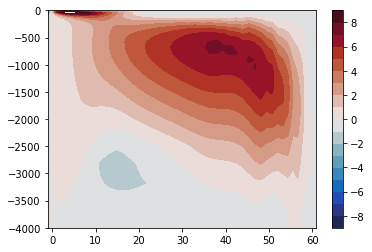

In [7]:
levels = np.linspace(vmin, vmax, 19)

moc = compute_moc(vo_to, grid_to)
ctf = plt.contourf(
    ds.gphiv.isel({'x_c':0}),
    -ds.gdepw_1d,
    moc.isel({'t':-1}),
    levels=levels,
    cmap=cm.cm.balance
)
plt.colorbar(ctf)

## In density coordinates

For this we need to compute the density field at the V point. We interpolate the temperature and the salinity at the V points, we use the simplified equation of state used by the model.

For now the function needs that the density field to be increasing with depth: we stabilize by hand the water column.

### Compute the density

We use here the potential density at the surface $\sigma_0$.

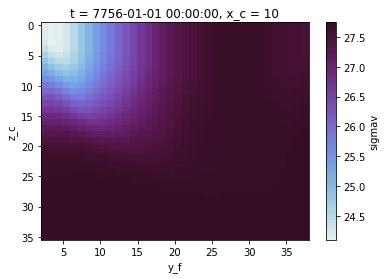

In [21]:
from xbasin.eos import compute_rho

rho = compute_rho(
    grid_fr.interp(ds.thetao,axis='Y', boundary='extrapolate'),
    grid_fr.interp(ds.so, axis='Y', boundary='extrapolate'),
    0,
    lambda1=4.9520e-2
) - 1000

# Try to stabilize the water column
for i in range(len(ds.z_c)-1):
    diff = (rho[:,i+1] - rho[:,i])
    mask = diff <= 0
    rho[:,i+1] -= mask * diff

ds['sigmav'] = rho

ds['sigmav'][{'t':0,'y_f':slice(2,-2),'x_c':10}].plot(cmap=cm.cm.dense)
plt.gca().invert_yaxis()

We compute the new density grid.

A new axis 'S' is created ('S' as sigma).

In [9]:
from xbasin import create_density_grid

ds = create_density_grid(
    ds,
    dd=0.01,
    rho=ds['sigmav']
)


ds.e1v[{'x_c':[0,-1]}] = 0
ds.e1t[{'x_c':[0,-1]}] = 0

metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'],
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'],
    ('Z',): ['e3t', 'e3u', 'e3v', 'e3w'],
    ('S',): ['e3t_s_1d', 'e3w_s_1d']
}
grid = xgcm.Grid(ds, periodic=False, metrics=metrics)
print(grid)
ds

<xgcm.Grid>
X Axis (not periodic):
  * center   x_c --> right
  * right    x_f --> center
Z Axis (not periodic):
  * center   z_c --> left
  * left     z_f --> center
Y Axis (not periodic):
  * center   y_c --> right
  * right    y_f --> center
T Axis (not periodic):
  * center   t
S Axis (not periodic):
  * center   s_c --> left
  * left     s_f --> center


<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, s_c: 501, s_f: 501, t: 5, x_c: 21, x_f: 21, y_c: 40, y_f: 40, z_c: 36, z_f: 36)
Coordinates:
  * z_f            (z_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 31.5 32.5 33.5 34.5
  * t              (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * x_c            (x_c) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19 20
  * y_c            (y_c) int64 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38 39
  * z_c            (z_c) int64 0 1 2 3 4 5 6 7 8 ... 27 28 29 30 31 32 33 34 35
  * x_f            (x_f) float64 0.5 1.5 2.5 3.5 4.5 ... 17.5 18.5 19.5 20.5
  * y_f            (y_f) float64 0.5 1.5 2.5 3.5 4.5 ... 36.5 37.5 38.5 39.5
  * s_c            (s_c) float64 0.0 1.0 2.0 3.0 4.0 ... 497.0 498.0 499.0 500.0
  * s_f            (s_f) float64 -0.5 0.5 1.5 2.5 ... 496.5 497.5 498.5 499.5
Dimensions without coordinates: axis_nbounds
Data variables:
    depthw_bounds  (z_f, axis_nbounds) float32 ...
    t_bounds       (t, axis_nbounds) object ...
    woce           (t, z_f, y_c, x_c) float32 ...
    e3w            (t, z_f, y_c, x_c) float32 ...
    deptht_bounds  (z_c, axis_nbounds) float32 ...
    e3t            (t, z_c, y_c, x_c) float32 ...
    thetao         (t, z_c, y_c, x_c) float32 0.0 24.280985 ... 0.0 0.0
    so             (t, z_c, y_c, x_c) float32 0.0 36.284115 ... 0.0 0.0
    rhop           (t, z_c, y_c, x_c) float32 ...
    tos            (t, y_c, x_c) float32 ...
    sos            (t, y_c, x_c) float32 ...
    zos            (t, y_c, x_c) float32 ...
    bn2            (t, z_c, y_c, x_c) float32 ...
    mldr10_1       (t, y_c, x_c) float32 ...
    relvor         (t, z_c, y_c, x_c) float32 ...
    qsr            (t, y_c, x_c) float32 ...
    qns            (t, y_c, x_c) float32 ...
    empmr          (t, y_c, x_c) float32 ...
    qt             (t, y_c, x_c) float32 ...
    saltflx        (t, y_c, x_c) float32 ...
    botpres        (t, y_c, x_c) float32 ...
    depthu_bounds  (z_c, axis_nbounds) float32 ...
    e3u            (t, z_c, y_c, x_f) float32 ...
    uos            (t, y_c, x_f) float32 ...
    uo             (t, z_c, y_c, x_f) float32 ...
    depthv_bounds  (z_c, axis_nbounds) float32 ...
    e3v            (t, z_c, y_f, x_c) float32 10.0 10.00081 ... 208.99274
    vos            (t, y_f, x_c) float32 ...
    vo             (t, z_c, y_f, x_c) float32 ...
    nav_lon        (y_c, x_c) float32 ...
    nav_lat        (y_c, x_c) float32 ...
    jpiglo         int32 ...
    jpjglo         int32 ...
    jpkglo         int32 ...
    jperio         int32 ...
    ln_zco         int32 ...
    ln_zps         int32 ...
    ln_sco         int32 ...
    ln_isfcav      int32 ...
    glamt          (y_c, x_c) float64 ...
    glamu          (y_c, x_f) float64 ...
    glamv          (y_f, x_c) float64 ...
    glamf          (y_f, x_f) float64 ...
    gphit          (y_c, x_c) float64 ...
    gphiu          (y_c, x_f) float64 ...
    gphiv          (y_f, x_c) float64 ...
    gphif          (y_f, x_f) float64 ...
    e1t            (y_c, x_c) float64 ...
    e1u            (y_c, x_f) float64 ...
    e1v            (y_f, x_c) float64 0.0 2.224e+05 2.224e+05 ... 1.086e+05 0.0
    e1f            (y_f, x_f) float64 ...
    e2t            (y_c, x_c) float64 ...
    e2u            (y_c, x_f) float64 ...
    e2v            (y_f, x_c) float64 ...
    e2f            (y_f, x_f) float64 ...
    ff_f           (y_f, x_f) float64 ...
    ff_t           (y_c, x_c) float64 ...
    e3t_1d         (z_c) float64 10.0 10.0 10.0 10.0 ... 365.0 393.2 420.1 439.2
    e3w_1d         (z_f) float64 ...
    e3t_0          (z_c, y_c, x_c) float64 ...
    e3u_0          (z_c, y_c, x_f) float64 ...
    e3v_0          (z_c, y_f, x_c) float64 ...
    e3f_0          (z_c, y_f, x_f) float64 ...
    e3w_0          (z_f, y_c, x_c) float64 ...
    e3uw_0         (z_f, y_c, x_f) float64 ...
    e3vw_0         (z_f, y_f, x_c) float64 ...
    top_level      (y_c, x_c) float64 ...
    bottom_level   (y_c, x_c

We compute the streamfunction in density (using a private function for now, will change later on).

We use the following formula:

$$\psi(\phi, \sigma) = - \iint_{\sigma^{\prime}(x,z) \geq \sigma} v \text{d} x \text{d} z$$

In [10]:
from xbasin._stream_functions import _compute_moc_in_density_coordinates

psi = _compute_moc_in_density_coordinates(
    v=ds.vo,
    rho=ds.sigmav,
    density_levels=ds.grhow_0,
    grid=grid,
    X='X',
    Z='Z'
)

Text(0.5, 0, 'latitude')

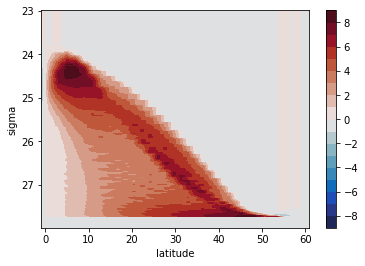

In [11]:
plt.contourf(ds.gphif.isel({'x_f':0}), ds.grhow_0, psi[{'t':0}].T, cmap=cm.cm.balance, levels=np.linspace(-vmax,vmax,19))
plt.colorbar()

plt.gca().invert_yaxis()

plt.ylabel('sigma')
plt.xlabel('latitude')

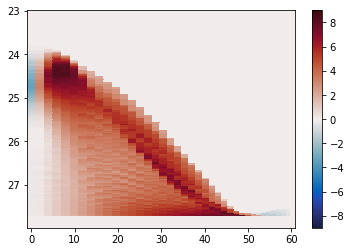

In [12]:
plt.pcolormesh(ds.gphif.isel({'x_f':0}), ds.grhow_0, psi[{'t':0}].T, cmap=cm.cm.balance, vmin=-vmax,vmax=vmax)
plt.colorbar()
plt.gca().invert_yaxis()

We can remap this streamfunction in depth coordinate by calculating the zonal mean depth of each density layer.

We use for now a naive and time consumming method.

In [13]:
%%time
from xbasin._stream_functions import compute_zonal_mean_depth_isopycnal

mean_depth_isopycnal = compute_zonal_mean_depth_isopycnal(
    rho=ds['sigmav'],
    density_levels=ds['grhow_0'],
    depth=grid.interp(ds.gdept_0, axis='Y', boundary='extend'),
    grid=grid
)

CPU times: user 5.45 s, sys: 0 ns, total: 5.45 s
Wall time: 5.45 s


In [14]:
mean_depth_isopycnal

<xarray.DataArray (s_f: 501, t: 5, y_f: 40)>
array([[[   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012]],

       [[   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012]],

       [[   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012],
        [   5.        ,    5.        ,    5.        , ...,
            5.        , 2006.41738027, 1400.37064012]],

       ...,

       [[4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012]],

       [[4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012]],

       [[4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012],
        [4202.36638374, 4202.36638374, 4166.94557535, ...,
         2930.21228442, 2006.41738027, 1400.37064012]]])
Coordinates:
  * s_f      (s_f) float64 -0.5 0.5 1.5 2.5 3.5 ... 496.5 497.5 498.5 499.5
  * t        (t) object 7756-01-01 00:00:00 ... 7796-01-01 00:00:00
  * y_f      (y_f) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 35.5 36.5 37.5 38.5 39.5

In [15]:
psi.coords['depth'] = mean_depth_isopycnal
psi.coords['phi'] = ds.gphif.isel({'x_f':0}).drop_vars('x_f')

Text(0.5, 0, 'latitude')

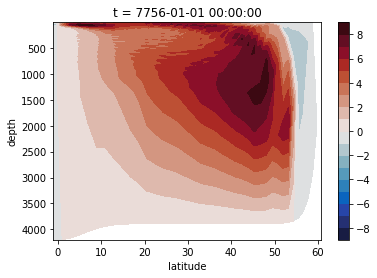

In [16]:
psi[{'t':0}].plot.contourf(
    x='phi',
    y='depth',
    cmap=cm.cm.balance,
    levels=np.linspace(-vmax,vmax,19)
)

plt.gca().invert_yaxis()

plt.ylabel('depth')
plt.xlabel('latitude')

Text(0.5, 0, 'latitude')

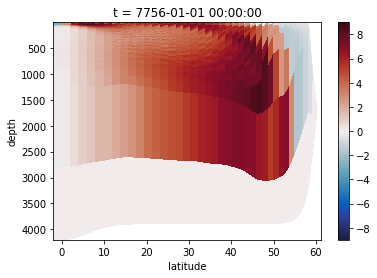

In [17]:
psi[{'t':0}].plot.pcolormesh(
    x='phi',
    y='depth',
    cmap=cm.cm.balance,
    vmin=-vmax,
    vmax=vmax
)

plt.gca().invert_yaxis()

plt.ylabel('depth')
plt.xlabel('latitude')